In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import (
    normalized_mutual_info_score,
    pair_confusion_matrix
)

from anndata import read_h5ad, AnnData
from sklearn.cluster import KMeans
import phenograph
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

## Pre-processing: filter markers and normalize data

In [2]:
adata = read_h5ad("../data/bcr_xl.h5ad")
adata

AnnData object with n_obs × n_vars = 172791 × 35
    obs: 'fcs_files', 'obs_ann_file', 'phenotype', 'population'
    var: 'pnn_label', 'pns_label'

In [3]:
adata = read_h5ad("/home/haidyi/Desktop/Data/Diffcyt/BCR_XL/processed/bcr_xl.h5ad")
marker_in_use = ['CD3', 'CD45', 'pNFkB', 'pp38', 'CD4', 'CD20', 'CD33', 'pStat5', 'CD123', 'pAkt', 'pStat1', 'pSHP2',
         'pZap70', 'pStat3', 'CD14', 'pSlp76', 'pBtk', 'pPlcg2', 'pErk', 'pLat', 'IgM', 'pS6', 'HLA-DR', 'CD7']
adata.var.index = adata.var['pns_label']
adata.var.index.name = 'index'
adata = adata[:,marker_in_use]

co_factor = 5.
# set seed for reproducibility
seed = 0

adata.X = np.arcsinh(adata.X / co_factor)

# Clustering

In [4]:
def ari(labels_true,labels_pred): 
    '''safer implementation of ari score calculation'''
    (tn, fp), (fn, tp) = pair_confusion_matrix(labels_true, labels_pred)
    tn=int(tn)
    tp=int(tp)
    fp=int(fp)
    fn=int(fn)

    # Special cases: empty data or full agreement
    if fn == 0 and fp == 0:
        return 1.0

    return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
                                       (tp + fp) * (fp + tn))

## Kmeans

In [5]:
%%time
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(adata.X)

CPU times: user 18.7 s, sys: 233 ms, total: 18.9 s
Wall time: 2.55 s


In [6]:
adata.obs['kmeans'] = kmeans.labels_
adata.obs['kmeans'] = adata.obs['kmeans'].astype("category")

true_labels = np.array(adata.obs['population'])
pred_labels = np.array(adata.obs['kmeans'])

ARI_kmean = ari(true_labels, pred_labels)
NMI_kmean = normalized_mutual_info_score(true_labels, pred_labels)
print("ARI: {:.3f}, NMI: {:.3f}".format(ARI_kmean, NMI_kmean))

Trying to set attribute `.obs` of view, copying.


ARI: 0.411, NMI: 0.508


## Leiden (nearest neighbors from umap)

In [7]:
%%time
# compute the neighbors and run leiden clustering
sc.pp.neighbors(adata, use_rep='X')
sc.tl.leiden(adata, key_added="leiden+umap", resolution=0.6)

CPU times: user 2min 9s, sys: 4.87 s, total: 2min 14s
Wall time: 1min 57s


In [8]:
true_labels = np.array(adata.obs['population'])
pred_labels = np.array(adata.obs['leiden+umap'])

ARI_leiden = ari(true_labels, pred_labels)
NMI_leiden = normalized_mutual_info_score(true_labels, pred_labels)
print("ARI: {:.3f}, NMI: {:.3f}".format(ARI_leiden, NMI_leiden))

ARI: 0.619, NMI: 0.604


## PhenoGraph (https://github.com/dpeerlab/PhenoGraph)

In [9]:
%%time
communities, graph, Q = phenograph.cluster(adata.X, clustering_algo='leiden', resolution_parameter=0.5)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 578.0146310329437 seconds
Jaccard graph constructed in 7.1785101890563965 seconds
Running Leiden optimization
Leiden completed in 84.17285871505737 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 672.9217760562897 seconds
CPU times: user 19min 39s, sys: 18min 56s, total: 38min 36s
Wall time: 11min 12s


In [10]:
adata.obs['phenograph'] = communities
adata.obs['phenograph'] = adata.obs['phenograph'].astype("category")

true_labels = np.array(adata.obs['population'])
pred_labels = np.array(adata.obs['phenograph'])

ARI_phenograph = ari(true_labels, pred_labels)
NMI_phenograph = normalized_mutual_info_score(true_labels, pred_labels)
print("ARI: {:.3f}, NMI: {:.3f}".format(ARI_phenograph, NMI_phenograph))

ARI: 0.634, NMI: 0.615


## Umap of cells

In [11]:
sc.tl.umap(adata, min_dist=0.3, random_state=seed)

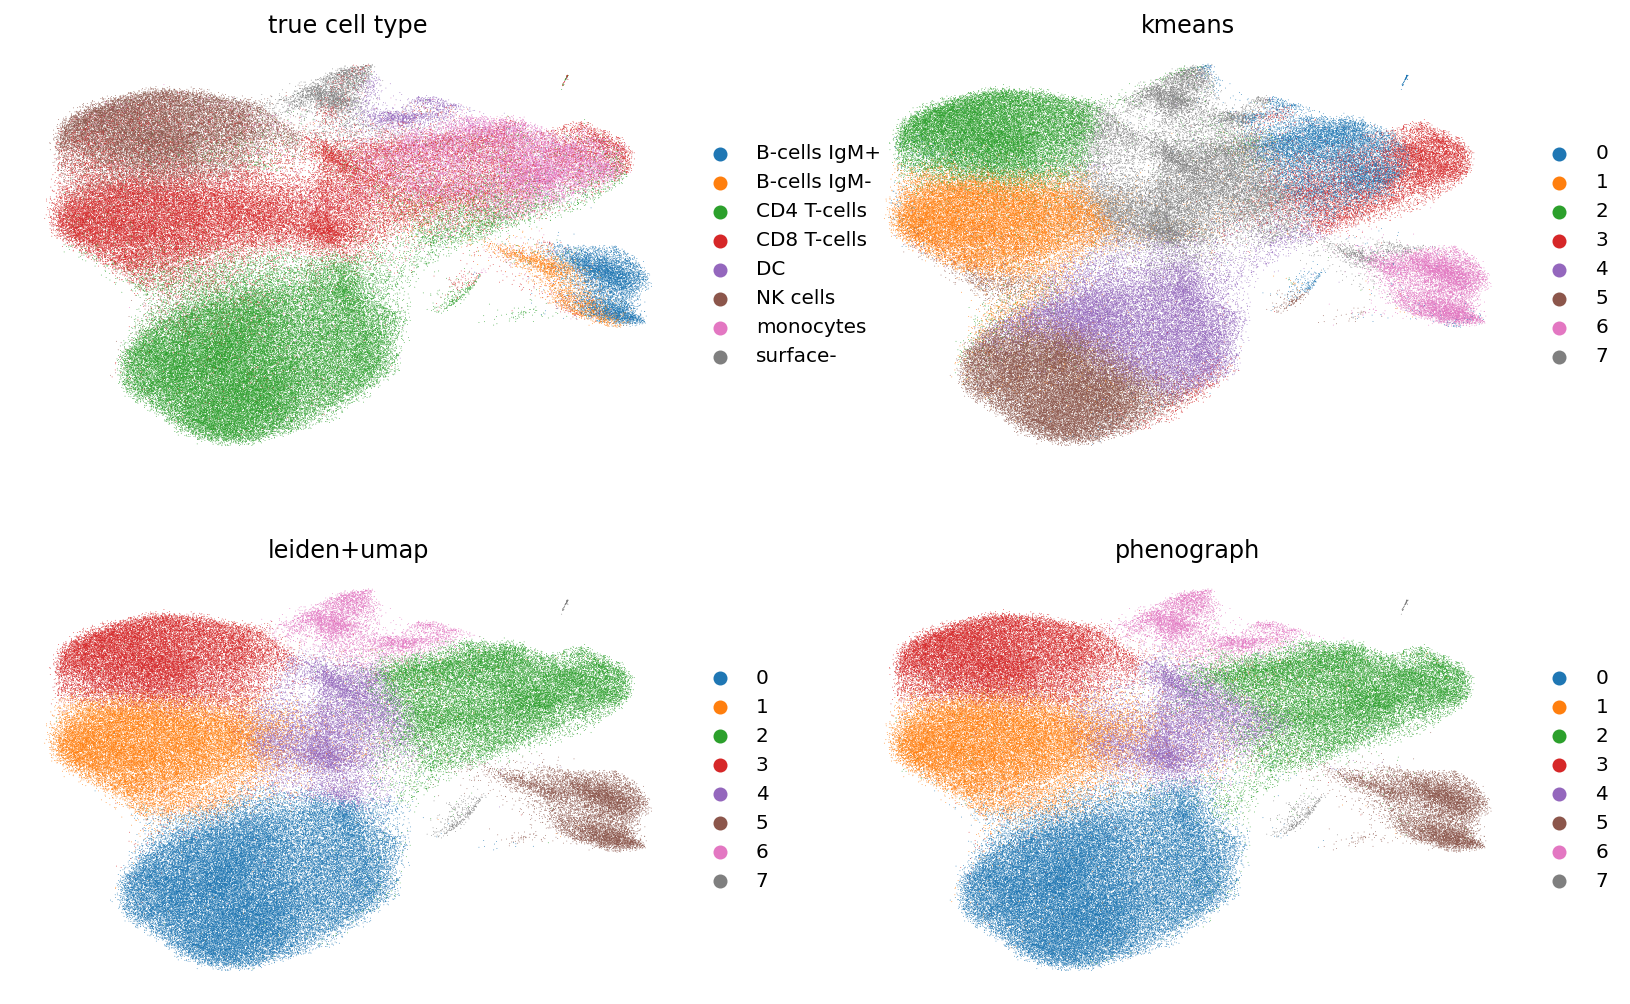

In [12]:
ax = sc.pl.umap(adata, ncols=2, color=["population", "kmeans", "leiden+umap", "phenograph"], frameon=False, show=False)
ax[0].set_title("true cell type")
plt.show()

# Sample Embedding

In [13]:
# get sample embeddings
def get_sample_representation(adata: AnnData, sample_idx: str, cluster: str, phenotype: str):
    df = adata.obs.groupby([sample_idx, cluster]).agg({cluster: 'count'}).rename(columns={cluster: f'{cluster}_count'}).reset_index().set_index(sample_idx)
    df_pheno = adata.obs.groupby(sample_idx).agg({phenotype: lambda x: x.iloc[0]})
    df = pd.concat([df, df_pheno], axis=1).reset_index()
    
    _dict = {
        name: group.set_index(cluster).to_dict()[f'{cluster}_count']
        for name, group in df.groupby([sample_idx, phenotype])
    }
    
    df = pd.DataFrame.from_dict(_dict, orient='index')
    # normalize the counts
    df = df.div(df.sum(axis=1), axis=0)
    adata = AnnData(df)
    adata.obs = adata.obs.reset_index()
    adata.obs.columns = [sample_idx, phenotype]
    return adata

# knn purity
def knn_purity(latent: np.array, label: np.array, n_neighbors=30):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(latent)
    indices = nbrs.kneighbors(latent, return_distance=False)[:, 1:]
    neighbors_labels = np.vectorize(lambda i: label[i])(indices)

    # pre cell purity scores
    scores = ((neighbors_labels - label.reshape(-1, 1)) == 0).mean(axis=1)
    res = [np.mean(scores[label == i]) for i in np.unique(label)]  # per cell-type purity
    
    # average over different cell types
    return np.mean(res)

In [14]:
sample_rep_truth       = get_sample_representation(adata, 'fcs_files', 'population',  'phenotype')
sample_rep_kmeans      = get_sample_representation(adata, 'fcs_files', 'kmeans',      'phenotype')
sample_rep_phenograph  = get_sample_representation(adata, 'fcs_files', 'phenograph',  'phenotype')
sample_rep_leiden_umap = get_sample_representation(adata, 'fcs_files', 'leiden+umap', 'phenotype')

/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Save the data for evaluation

In [15]:
# true label gating
sample_rep_truth.write_h5ad('../results/bcr_xl_true_gating.h5ad', compression='gzip')
# kmeans gating
sample_rep_kmeans.write_h5ad("../results/bcr_xl_kmeans.h5ad", compression='gzip')
# phenograph gating
sample_rep_phenograph.write_h5ad("../results/bcr_xl_phenograph.h5ad", compression='gzip')
# leiden with umap gating
sample_rep_leiden_umap.write_h5ad("../results/bcr_xl_leiden_umap.h5ad", compression='gzip')

/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phenotype' as categorical
/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phenotype' as categorical
/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories 